In [128]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [129]:
def p_t(p_0,t,n,Vals,Vecs,l):
    p_t=0
    for i in range(n):
        p_t += Vals[l,i]**t *(Vecs[l,:,i].reshape(50,50)*p_0).sum()*Vecs[l,:,i] 
    return p_t.reshape(50,50)
# p = pm*pc
# pm := <p>_2
# pc := p/pm


def marginal_p(p):
    # axis=0 is the fast coordinate
    pm = np.trapz(p,x,axis=0)
    I = np.trapz(pm,x)
    return pm/I

def conditional_p(p):
    margin = marginal_p(p)
    margin[margin==0]=1.
    
    pc=(p/margin[None])
    
    I = np.trapz(pc,x,axis=0)
    I[I==0]=1.
    pc/=I[:,None]
    return pc

def dt_p_m(pm,pc,sigma=15.):
    
    I = np.trapz(pm,x)
    pm/=I
    I = np.trapz(pc,x,axis=0)
    pc/=I[None]
    
    pad = np.zeros((2+pm.shape[0]))
    pad[1:-1]=pm    
    pm_11=(pad[2:]-2*pad[1:-1]+pad[:-2] )/dx**2
    
    
    pad = np.zeros((2+pm.shape[0]))
    pad[1:-1]=np.trapz(pc*v1,x,axis=0)*pm
    D1Fm = (pad[2:]-pad[:-2])/2./dx
    return sigma*pm_11 ,D1Fm

def dt_p_c(p,sigma=15.):
    pc = conditional_p(p)
    pm = marginal_p(p)
#     I1 = np.trapz(pm,x)
#     pm/=I1
#     I2 = np.trapz(pc,x,axis=0)
#     pc/=I2[:,None]
    
    pad = np.zeros((2+pc.shape[0],pc.shape[0]))
    pad[1:-1,:]=pc    
    pc_22=(pad[2:]-2*pad[1:-1]+pad[:-2])/dx**2
    
    pad = np.zeros((2+pc.shape[0],pc.shape[0]))
    pad[1:-1]=(v2*pc)
    D2V2p_c = (pad[2:]-pad[:-2])/2./dx
    
    pad = np.zeros((pc.shape[0],2+pc.shape[0]))
    pad[:,1:-1]=pc    
    pc_11=(pad[:,2:]-2*pad[:,1:-1]+pad[:,:-2])/dx**2
    
    pad = np.zeros((pc.shape[0],2+pc.shape[0]))
    pad[:,1:-1]=(v1*pc)
    D1V1p_c = (pad[:,2:]-pad[:,:-2])/2./dx
    
    pad = np.zeros((pc.shape[0],2+pc.shape[0]))
    pad[:,1:-1]=pc
    pc_1 = (pad[:,2:]-pad[:,:-2])/2./dx
    
    
    pad = np.zeros((2+pm.shape[0]))
    pad[1:-1]=np.trapz(pc*v1,x,axis=0)*pm
    D1Fm = (pad[2:]-pad[:-2])/2./dx
    
    pad = np.zeros((2+pm.shape[0]))
    pad[1:-1]=pm    
    pm_1=(pad[2:]-pad[:-2])/2./dx
    
    pm[pm==0]=1
    
    
    return sigma*pc_22 , D2V2p_c , sigma*pc_11 , D1V1p_c  , -D1Fm*pc/pm , pm_1/pm*(sigma*pc_1+v1*pc)


def RK4(p,h=0.0151):
    pc = conditional_p(p)
    pm= marginal_p(p)
    
    k1_pc = dt_p_c(pm,pc)  
    k2_pc = dt_p_c(pm,pc+h/2.*k1_pc)   
    k3_pc = dt_p_c(pm,pc+h/2.*k2_pc)  
    k4_pc = dt_p_c(pm,pc+h*k3_pc)
    pc_new = (pc+h/6.*(k1_pc+2.*k2_pc+2.*k3_pc+k4_pc))
    
    k1_pm = dt_p_m(pm,pc)
    k2_pm = dt_p_m(pm+h/2.*k1_pm,pc)
    k3_pm = dt_p_m(pm+h/2.*k2_pm,pc)
    k4_pm = dt_p_m(pm+h*k3_pm,pc)
    pm_new = (pm+h/6.*(k1_pm+2.*k2_pm+2.*k3_pm+k4_pm))
    return pm_new*pc_new

def RK4_pc_first(p,h=0.0151):
    pc = conditional_p(p)
    pm= marginal_p(p)    
    
    k1_pc = dt_p_c(pm,pc)  
    k2_pc = dt_p_c(pm,pc+h/2.*k1_pc)   
    k3_pc = dt_p_c(pm,pc+h/2.*k2_pc)  
    k4_pc = dt_p_c(pm,pc+h*k3_pc)
    pc_new = (pc+h/6.*(k1_pc+2.*k2_pc+2.*k3_pc+k4_pc))
    
    k1_pm = dt_p_m(pm,pc_new)
    k2_pm = dt_p_m(pm+h/2.*k1_pm,pc_new)
    k3_pm = dt_p_m(pm+h/2.*k2_pm,pc_new)
    k4_pm = dt_p_m(pm+h*k3_pm,pc_new)
    pm_new = (pm+h/6.*(k1_pm+2.*k2_pm+2.*k3_pm+k4_pm))
#     print pc.shape
    return pm_new*pc_new

def RK4_pm_first(p,h=0.0151):
    pc = conditional_p(p)
    pm= marginal_p(p)    
    
    
    k1_pm = dt_p_m(pm,pc)
    k2_pm = dt_p_m(pm+h/2.*k1_pm,pc)
    k3_pm = dt_p_m(pm+h/2.*k2_pm,pc)
    k4_pm = dt_p_m(pm+h*k3_pm,pc)
    pm_new = (pm+h/6.*(k1_pm+2.*k2_pm+2.*k3_pm+k4_pm))
    
    k1_pc = dt_p_c(pm_new,pc)  
    k2_pc = dt_p_c(pm_new,pc+h/2.*k1_pc)   
    k3_pc = dt_p_c(pm_new,pc+h/2.*k2_pc)  
    k4_pc = dt_p_c(pm_new,pc+h*k3_pc)
    pc_new = (pc+h/6.*(k1_pc+2.*k2_pc+2.*k3_pc+k4_pc))
    
    return  pm_new*pc_new

def RK4_p(p,h=0.0151):
    
    k1_p = dt_p(p)
    
    k2_p = dt_p(p+h/2.*k1_p)
       
    k3_p = dt_p(p+h/2.*k2_p)
       
    k4_p = dt_p(p+h*k3_p)
    return (p+h/6.*(k1_p+2.*k2_p+2.*k3_p+k4_p))

def dt_p(p,sigma=15.):
    I0=np.trapz(np.trapz(p,x),x)
    p/=I0

    pad = np.zeros((2+p.shape[0],p.shape[0]))
    pad[1:-1,:]=p    
    p_22=(pad[2:]-2*pad[1:-1]+pad[:-2])/dx**2
    
    pad = np.zeros((p.shape[0],2+p.shape[0]))
    pad[:,1:-1]=p    
    p_11=(pad[:,2:]-2*pad[:,1:-1]+pad[:,:-2])/dx**2
    
    pad = np.zeros((2+p.shape[0],p.shape[0]))
    pad[1:-1]=(v2*p)
    D2V2p = (pad[2:]-pad[:-2])/2./dx
    
    pad = np.zeros((p.shape[0],2+p.shape[0]))
    pad[:,1:-1]=(v1*p)
    D1V1p = (pad[:,2:]-pad[:,:-2])/2./dx
    return sigma*(p_11+p_22)+D1V1p+D2V2p


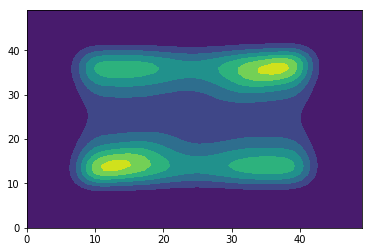

In [143]:
plt.contourf(Vecs[10,:,0].reshape(50,50))
np.save('Eigenvectors_Shortened',Vecs[:,:10,:])

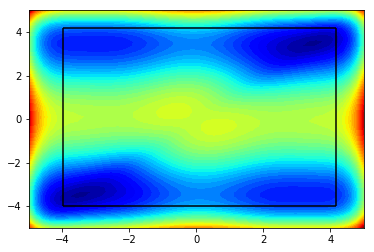

In [130]:
Vals = np.load('Eigenvalues.npy',mmap_mode='r')
Vecs = np.load('Eigenvectors.npy',mmap_mode='r')
lags = np.loadtxt('fff0/data/tau.txt')

k1=0.003
a1=3.3
k2=1.0
a2=3.5
k12=-50
c=1  
def V(x,y):# actually never used

    return k1 * pow( (x*x - a1*a1), 4) + k2 * pow(y*y - a2*a2, 2) + k12 / np.sqrt((x - y)*(x - y) + c*c) ; 

def DVx(x,y):
    return 8 * k1 * x * pow( (x*x - a1*a1), 3) - k12 * (x - y) / pow((x - y)*(x - y) + c*c, 1.5); 

def DVy(x,y):
    
    return 4 * k2 * y * (y*y - a2*a2) + k12 * (x - y) / pow((x - y)*(x - y) + c*c, 1.5); 

res=50
x = np.linspace(-5,5,res)
dx = np.diff(x).mean()
X,Y = np.meshgrid(x,x)
v = V(X,Y)
v1 = DVy(X,Y)
v2 = DVx(X,Y)
plt.contourf(x,x,v,50,cmap=plt.cm.jet)
plt.hlines(x[5],x[-5],x[5])
plt.hlines(x[-5],x[-5],x[5])
plt.vlines(x[5],x[-5],x[5])
plt.vlines(x[-5],x[-5],x[5])



In [131]:
print lags
c=25
p_0 = np.zeros((res,res))
p_0[c,:]=np.exp(-(x-x[c])**2)
p_0[:,c]+=np.exp(-(x-x[c])**2)
p_0 = np.random.rand(res,res)
p_0 = np.ones((res,res))
# p_0[c,c]=1
I0=np.trapz(np.trapz(p_0,x),x)
p_0/=I0

[  5.  10.  20.  30.  50.  70. 100. 200. 300. 400. 500.]


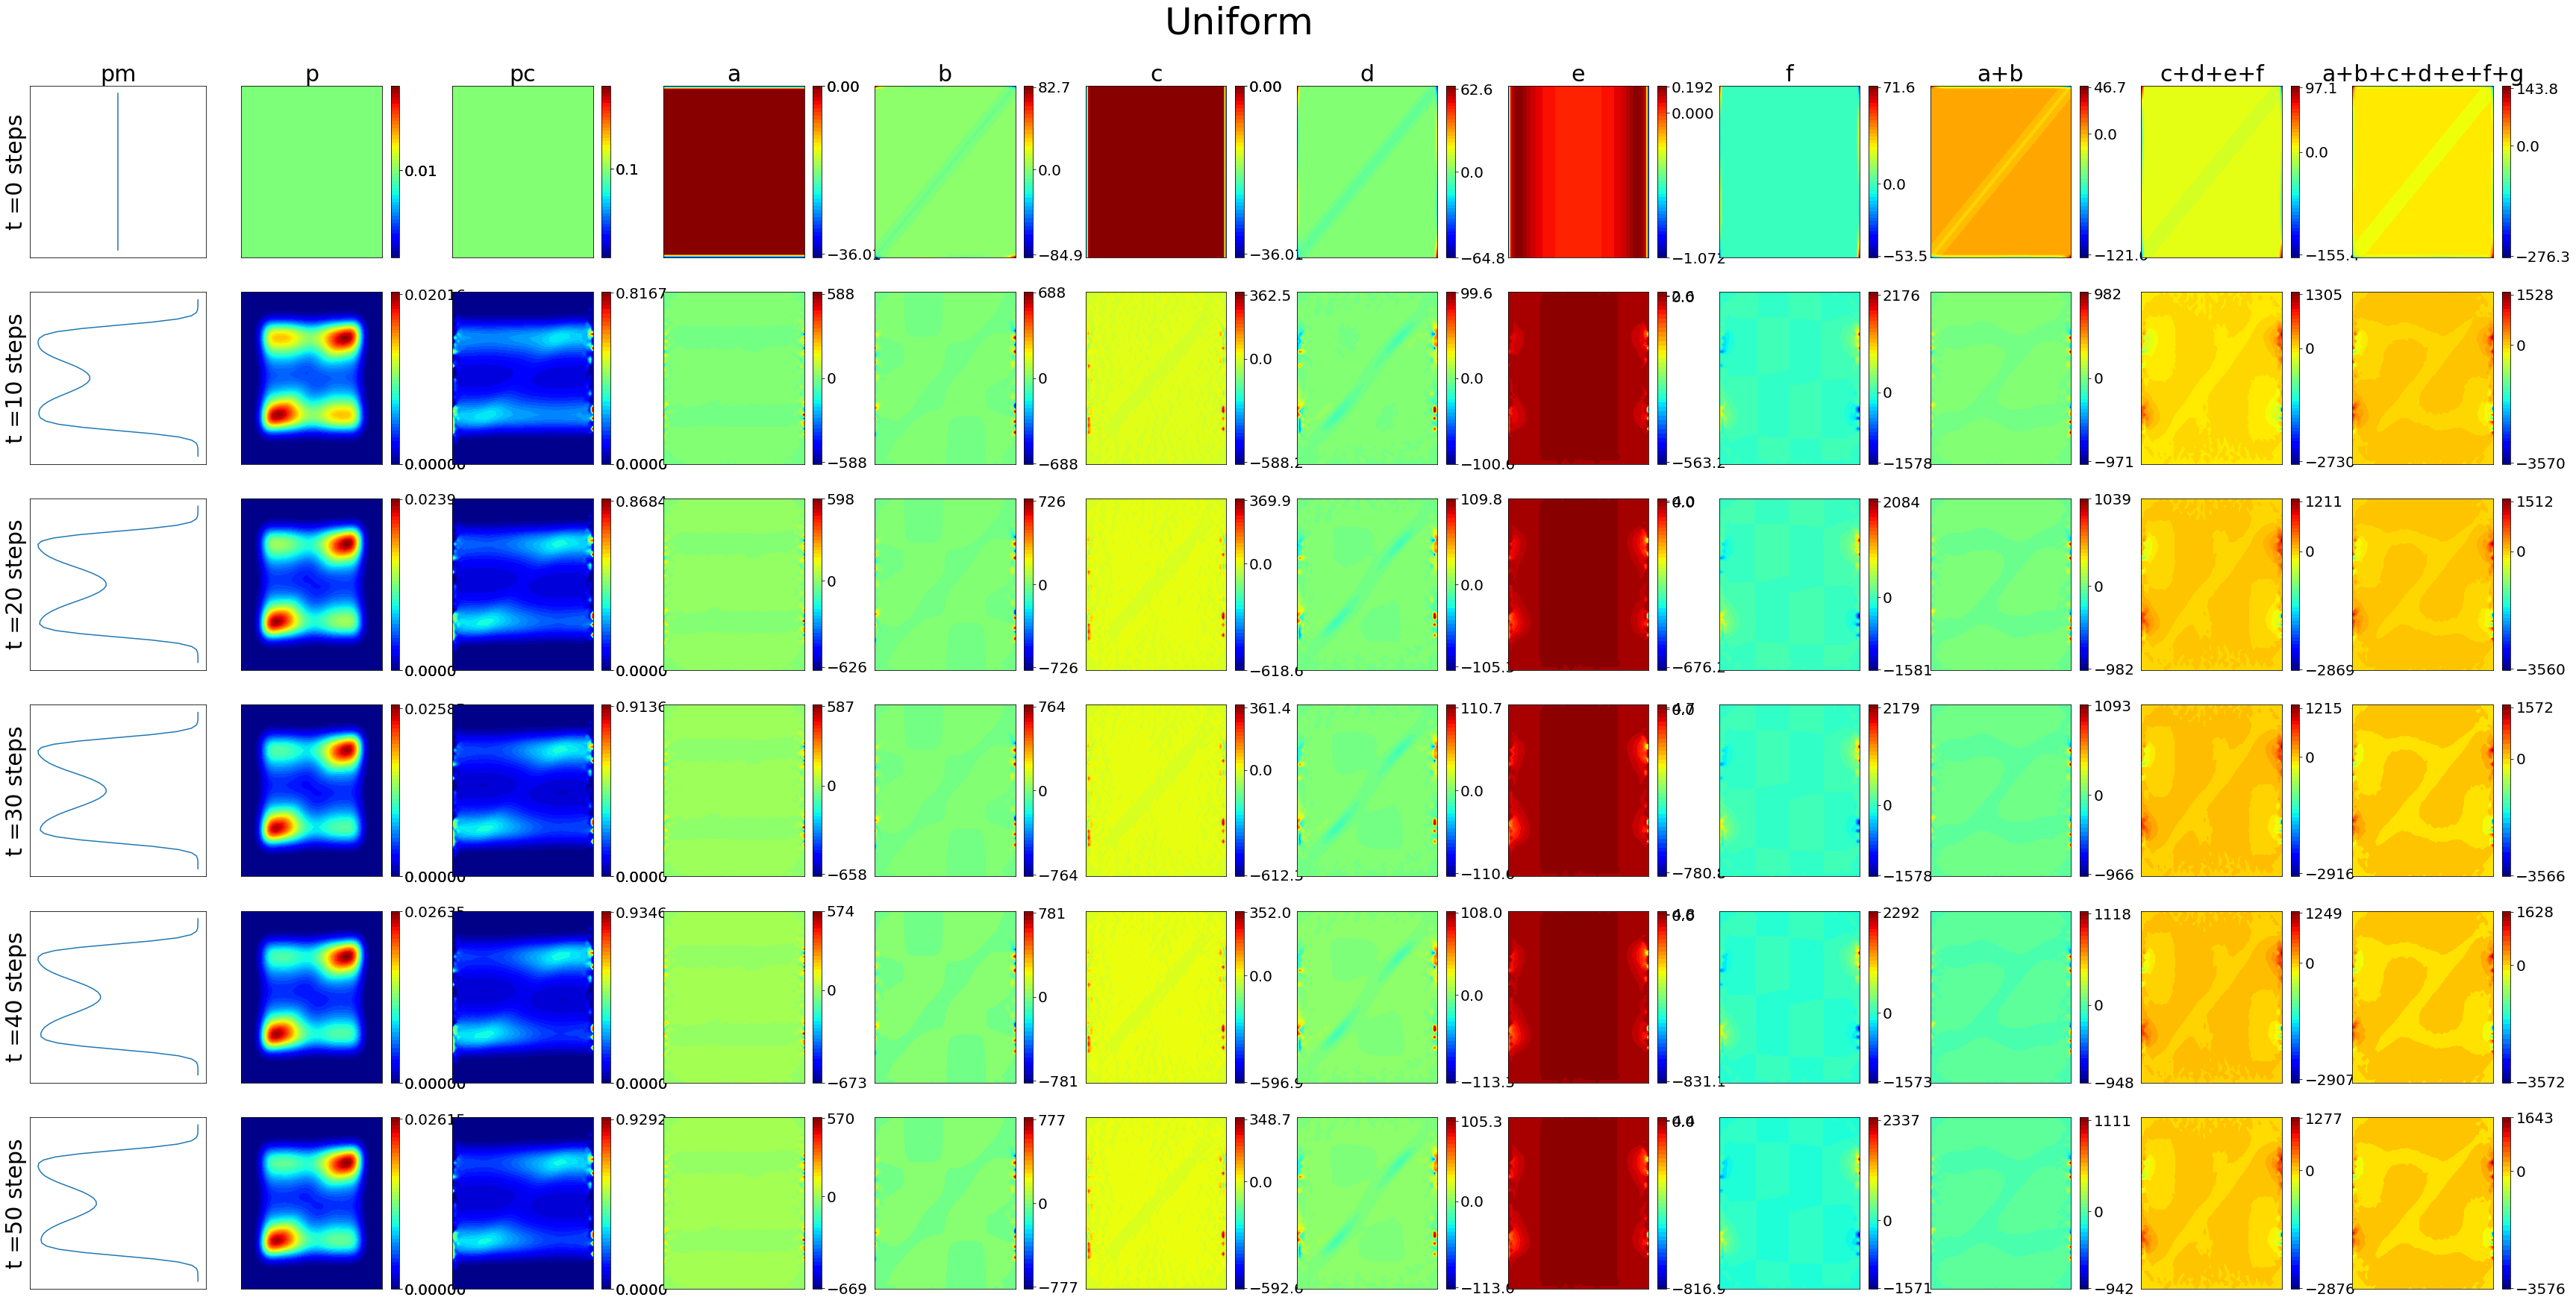

In [132]:


p=p_0
fig=plt.figure(figsize=(60,50))
terms = [] 
k=1
h = 0

pc = conditional_p(p)
pm = marginal_p(p)
a,b,c,d,e,f = dt_p_c(p)
terms.append([a,b,c,d,e,f])
titles = ['pm','p','pc','a','b','c','d','e','f','a+b','c+d+e+f','a+b+c+d+e+f']
if k == 1:
    k=0
    ax=fig.add_subplot(10,12,1+h)
    ax.plot(-pm,x)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[h],size=30)
    ax.set_ylabel('t ='+str(0)+' steps',size=30)
    h+=1
    for g in [p,pc,a,b,c,d,e,f,a+b,c+d+e+f,a+b+c+d+e+f]:
        ax=fig.add_subplot(10,12,1+h)
        G = g#[5:-5,5:-5]
        cont=ax.contourf(G,50,cmap=plt.cm.jet)
        gmin = np.min(G)
        gmax = np.max(G)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[h],size=30)
        cbar = plt.colorbar(cont,ticks=[gmin,0,gmax])
        cbar.ax.tick_params(labelsize=20)
#             cbar.ax.set_
        h+=1

k+=1


for i in np.arange(5):
    p = p_t(p,i,5,Vals,Vecs,1)
    p[p<0]=0
    pc = conditional_p(p)
    pm = marginal_p(p)
    a,b,c,d,e,f = dt_p_c(p)
    terms.append([a,b,c,d,e,f])
    if k == 1:
        k=0
        ax=fig.add_subplot(10,12,1+h)
        ax.plot(-marginal_p(p),x)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('t ='+str((i+1)*10)+' steps',size=30)
        h+=1
        for g in [p,pc,a,b,c,d,e,f,a+b,c+d+e+f,a+b+c+d+e+f]:
            ax=fig.add_subplot(10,12,1+h)
            G = g#[5:-5,5:-5]
            cont=ax.contourf(G,50,cmap=plt.cm.jet)
            gmin = np.min(G)
            gmax = np.max(G)
            ax.set_xticks([])
            ax.set_yticks([])
            cbar = plt.colorbar(cont,ticks=[gmin,0,gmax])
            cbar.ax.tick_params(labelsize=20)
#             cbar.ax.set_
            h+=1

    k+=1
plt.suptitle('Uniform',size=50,y=0.91)
plt.savefig('Uniform.pdf',bbox_inches='tight')

In [136]:
A = np.array([[1,2],[3,4]])
b = np.array([1,2])
print A+b[None]
print A+b[:,None]

[[2 4]
 [4 6]]
[[2 3]
 [5 6]]


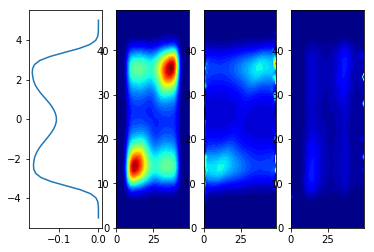

In [138]:
pc = conditional_p(p)
pm = marginal_p(p)

plt.subplot(141)
plt.plot(-pm,x)
plt.subplot(142)
plt.contourf(p,50,cmap=plt.cm.jet)
plt.subplot(143)
pc1=p/pm
I1 = np.trapz(pc1,x,axis=0)
I1[I1==0]=1
pc1/=I1[:,None]
plt.contourf(pc1,50,cmap=plt.cm.jet)
plt.subplot(144)
pc2=p/pm[:,None]
I2 = np.trapz(pc2,x,axis=0)
I2[I2==0]=1
pc2/=I2[:,None]
plt.contourf(pc2.T*pm,50,cmap=plt.cm.jet)